# KD-drzewa

## Narzędzie graficzne
Do wizualizacji programu użyto narzędzia graficznego mgr. inż. Krzysztofa Podsiadło.

# Rozwiązanie
Sprawdzenie wyniku, dla danego przykładu (bez wizualizacji)

In [8]:
%matplotlib notebook
from kdtree.kdtreeAuxClasses import Range
from kdtree.kdtree import KDTree

points = [(3, 1), (1, 2), (6, 0), (7, 5), (4, 3)]
testTree = KDTree(points)

searchingRange = Range(0, 7, 0, 5)
print(testTree.search(searchingRange))

[(1, 2), (3, 1), (4, 3), (6, 0), (7, 5)]


## Wizualizacja
### Inicjalizacja


<IPython.core.display.Javascript object>


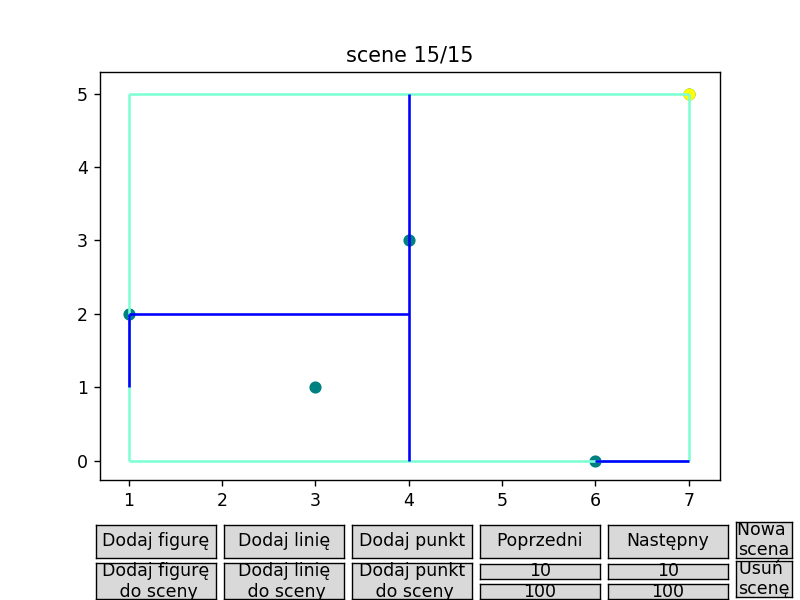

In [5]:
from graphicTool import *
from kdtree.kdtreevis import KDTreeVis

points = [(3, 1), (1, 2), (6, 0), (7, 5), (4, 3)]
testKDTreeVis = KDTreeVis(points)
searchingRange = Range(2, 5, 0, 4)

plot = testKDTreeVis.getInitPlot()
plot.draw()

### Przeszukiwanie

<IPython.core.display.Javascript object>


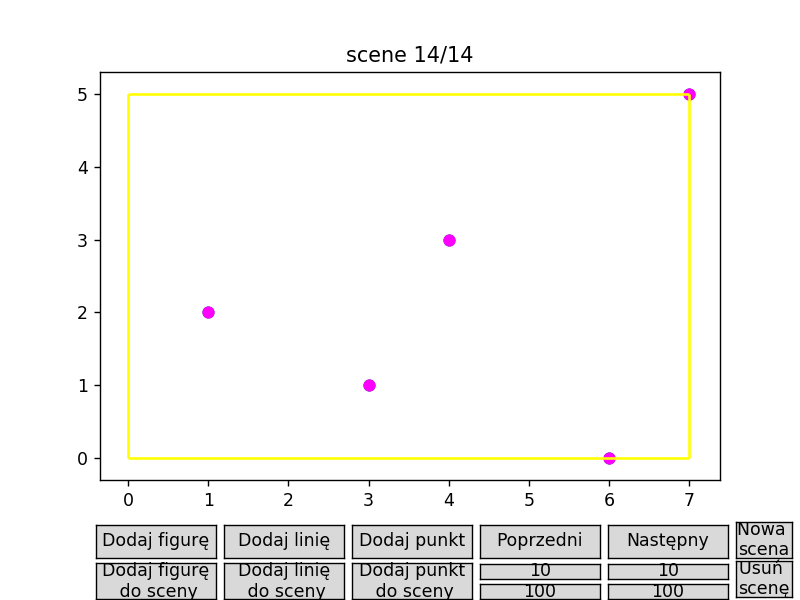

In [11]:
testKDTreeVis.search(searchingRange)
plot = testKDTreeVis.getSearchPlot()
plot.draw()
testKDTreeVis.clearVis()